<a href="https://colab.research.google.com/github/tomonari-masada/course2021-stats2/blob/main/03_PyMC_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3. PyMC3入門 (2)
* 今回、PyMC3を解説するに当たっては、PyMC3の公式サイトを参考にした。
 * https://docs.pymc.io/notebooks/api_quickstart.html

## 3.0 準備

In [ ]:
!pip install arviz==0.10
!pip install pymc3==3.10

In [ ]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm

warnings.simplefilter(action="ignore", category=FutureWarning)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

SEED = 1234

## 3.1 PyMC3によるMCMC

### 3.1.0 MCMC（マルコフ連鎖モンテカルロ）とは
* ベイズ的なモデリングにおいて、事後分布を推論する方法の一つ。
 * もう一つの方法に、変分推論(variational inference)がある。
* MCMCは、事後分布からのサンプルを通して、事後分布そのものを知ろうとする方法。
* モデルが複雑になるほど、事後分布$p(\theta|X)$からのサンプリングは、難しくなっていく。
 * 比較的シンプルなモデルについては、良いサンプリングができる（例：LDAのcollapsed Gibbs sampling）。
* この授業では、MCMCの実際上の使い方を説明する。理屈はあまり説明しない。

### 3.1.1 PyMC3における確率モデルの定義

* PyMC3では、ベイズ的モデルを定義し、観測データを設定すれば、関数`pm.sample()`を使うことで、事後分布からのサンプルを得ることができる。

* 例題
 * 数値データがたくさんある。標準偏差は1らしい。平均は0に近いが、0からずれているかもしれない。この平均を知りたい。
 * ベイズ的なモデリングによって、平均がいくらの可能性がどのくらい、という、事後分布を得ることにする。

* そこで、下記のモデルを使う。
$$ \mu \sim N(0, 1) $$
$$ x \sim N(\mu, 1) $$
* このモデルをPyMC3で書くと、次のようになる。

In [ ]:
model = pm.Model()

with model:
  mu = pm.Normal("mu", mu=0, sigma=1)
  obs = pm.Normal("obs", mu=mu, sigma=1, observed=np.random.randn(100))

### 3.1.2 PyMC3によるMCMCの実行

* `mu`が従う事後分布からサンプルを得るには、以下のようにすればよい。
* `tune`は、最初の何個のサンプルを捨てるかを指定する引数。
 * MCMCで得られるサンプルは、最初のほうのものは、通常、捨てる。
* return_inferencedataについては[ここ](https://docs.pymc.io/api/inference.html#pymc3.sampling.sample)を参照。
 * これをTrueにすると、arvizに渡せる形式でサンプリング結果が返ってくる。

In [ ]:
with model:
  trace = pm.sample(2000, tune=1500, random_seed=SEED, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [mu]


Sampling 2 chains for 1_500 tune and 2_000 draw iterations (3_000 + 4_000 draws total) took 6 seconds.


* chainとは、サンプルの一つの系列のこと。
* MCMCによるサンプリングでは、直前のサンプルを少し変化させることで、次のサンプルを求める。
 * 前回説明したとおり、この変化のさせ方が賢いので、ちゃんと事後分布からのサンプルになる。
* ということは、サンプルは、初期値から始まって、一筋の系列をなしている。この系列をchainと呼ぶ。
* chainが一つだけだと心もとないので、普通は、複数のchainを走らせる。
* PyMC3のデフォルトの設定では、chainの数は、利用可能なコア数にしたがって自動的に決められる。

* **注意:** divergenceが0でなかったら、色々と考え直す必要がある。（後の回で説明します。）
 

* 上のコードを実行すると、`trace`にサンプリング結果が保存されている。
* `trace.posterior`によって事後分布の情報にアクセスできる。

In [ ]:
trace.posterior

<xarray.Dataset>
Dimensions:  (chain: 2, draw: 2000)
Coordinates:
  * chain    (chain) int64 0 1
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 1993 1994 1995 1996 1997 1998 1999
Data variables:
    mu       (chain, draw) float64 0.09284 0.1003 0.1111 ... 0.1785 0.1785 0.226
Attributes:
    created_at:                 2021-04-18T14:34:11.946841
    arviz_version:              0.10.0
    inference_library:          pymc3
    inference_library_version:  3.10.0
    sampling_time:              5.900479793548584
    tuning_steps:               1500

* サンプリングに使うcoreの数、生成するchainの数を指定する場合は、以下のようにする。
 * coresがコア数、chainsがchainの数。

In [ ]:
with pm.Model() as model:
  mu = pm.Normal("mu", mu=0, sigma=1)
  obs = pm.Normal("obs", mu=mu, sigma=1, observed=np.random.randn(100))
  
  trace = pm.sample(2000, tune=1500, cores=4, chains=4, random_seed=SEED, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_500 tune and 2_000 draw iterations (6_000 + 8_000 draws total) took 13 seconds.


* NUTS(No-U-Turn-Sampler)は、PyMC3においてデフォルトで使われるサンプラー。
* HMCの改良版。詳細は割愛。
 * https://mc-stan.org/docs/2_26/reference-manual/hmc-chapter.html
 * https://arxiv.org/abs/1111.4246

* chainは4本あり、それぞれ2000のサンプルから成っている。

In [ ]:
trace.posterior["mu"].shape

(4, 2000)

* 特定のchainだけ選ぶ方法は以下の通り。

In [ ]:
trace.posterior["mu"].sel(chain=0).shape

(2000,)

* 特定のchainの、最初の10個のサンプルだけ見てみる。

In [ ]:
trace.posterior["mu"].sel(chain=1)[:10]

<xarray.DataArray 'mu' (draw: 10)>
array([ 0.13402428, -0.06065357,  0.17258797,  0.17082169,  0.17082169,
        0.17082169, -0.13347903, -0.13347903, -0.05289961,  0.03863161])
Coordinates:
    chain    int64 1
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 9

* chainの中身のデータ型はxarrayの配列。
 * NumPyの配列とは違う。

In [ ]:
type(trace.posterior["mu"])

xarray.core.dataarray.DataArray

* `.data`でndarrayへ変換できる。

In [ ]:
type(trace.posterior["mu"].data)

numpy.ndarray

In [ ]:
trace.posterior["mu"].data.shape

(4, 2000)

* サンプルのヒストグラムを描くと、事後分布の大体の形が分かる。

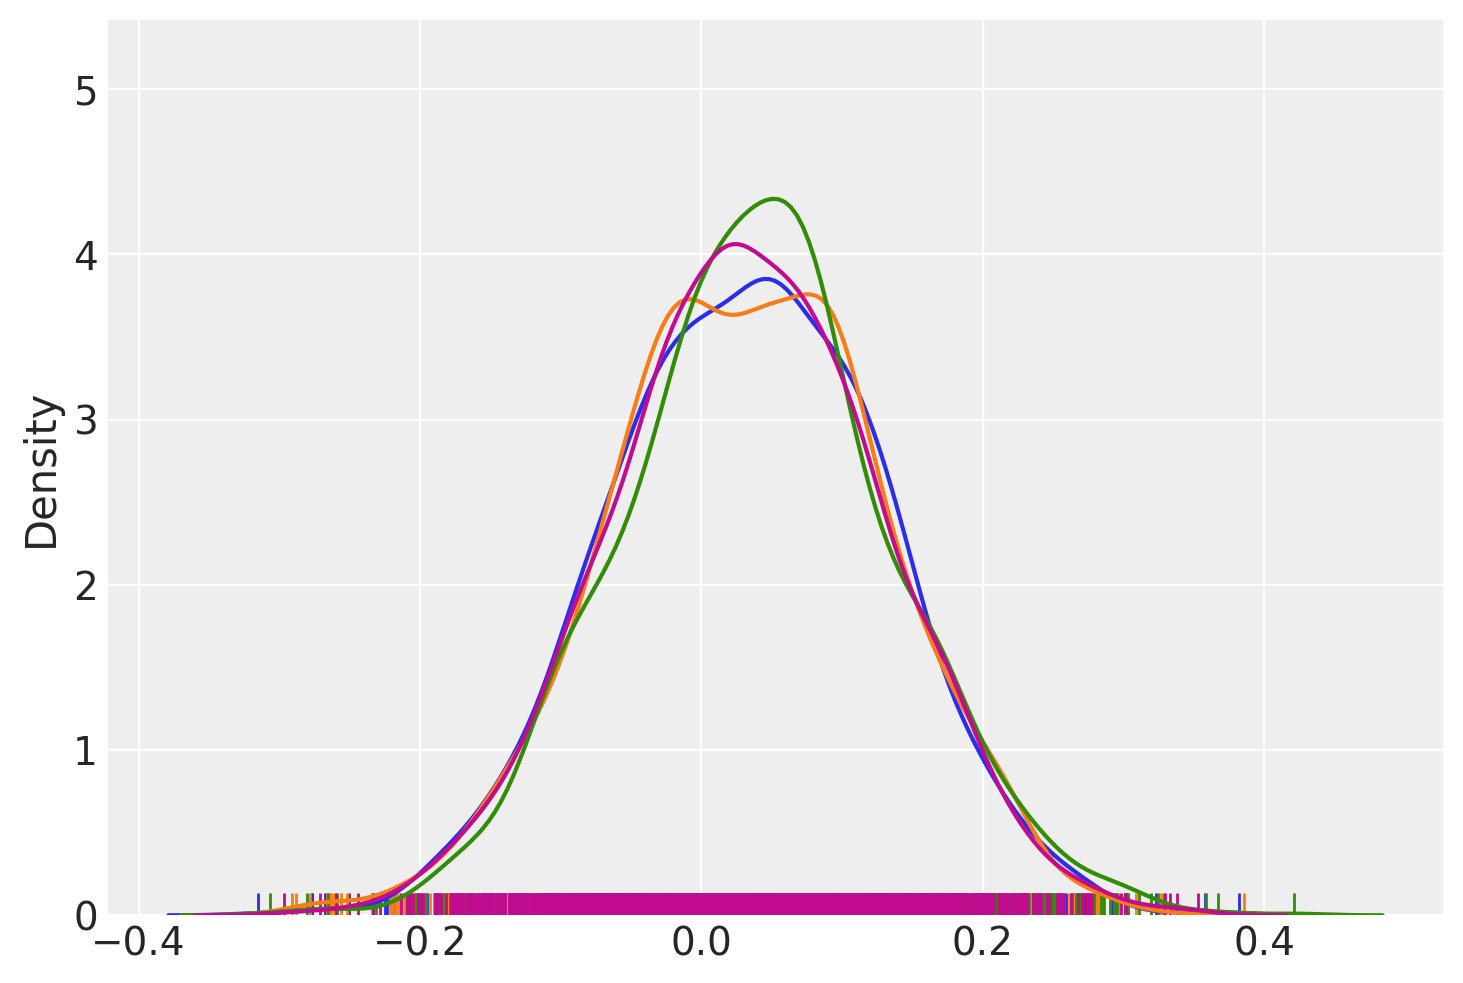

In [ ]:
import seaborn as sns

for i in range(trace.posterior["mu"].data.shape[0]):
  sns.distplot(trace.posterior["mu"].data[i], rug=True, hist=False)

* ピークが0付近に来ていなければ、観測データの平均を確認してみる。

In [ ]:
obs.observations.mean()

0.035132955234896145

* さて、chainが４本からなるこのサンプルは、うまく事後分布を表しているのだろうか？
 * 以下、サンプルの分析手法を紹介する。

## 3.2 PyMC3で使えるサンプリング手法

* PyMC3のドキュメントには、以下のように書いてある。



> "For almost all continuous models, ``NUTS`` should be preferred."



* ``NUTS``では良いサンプルが得られない場合、``Metropolis``を使う人が多いが、これは良くない選択だ、とも書いてある。
* ``NUTS``でうまくいかない時は、初期値を変えるか、変数変換をするのが良い。
* Metropolis法では、effective sample sizeが小さくなってしまうことが多い。
 * つまり、$x^{new}$が新しい値に更新されないことが多い。

* PyMC3で実装されているサンプラーの一覧。

In [ ]:
list(filter(lambda x: x[0].isupper(), dir(pm.step_methods)))

['BinaryGibbsMetropolis',
 'BinaryMetropolis',
 'CategoricalGibbsMetropolis',
 'CauchyProposal',
 'CompoundStep',
 'DEMetropolis',
 'DEMetropolisZ',
 'DEMetropolisZMLDA',
 'ElemwiseCategorical',
 'EllipticalSlice',
 'HamiltonianMC',
 'LaplaceProposal',
 'MLDA',
 'Metropolis',
 'MetropolisMLDA',
 'MultivariateNormalProposal',
 'NUTS',
 'NormalProposal',
 'PGBART',
 'PoissonProposal',
 'RecursiveDAProposal',
 'Slice',
 'UniformProposal']

## 3.3 サンプリング結果の分析
 * https://docs.pymc.io/notebooks/sampler-stats.html
 * https://docs.pymc.io/notebooks/Diagnosing_biased_Inference_with_Divergences.html 
 * https://www.statlect.com/fundamentals-of-statistics/Markov-Chain-Monte-Carlo-diagnostics

* MCMCを使うときには、サンプルが良いサンプルか悪いサンプルかを、気にしないといけない。
* 例えば、chainが事後分布の定義域のごく狭い範囲しか踏査していないかもしれない。

### 3.3.1 ヒストグラム


* 例題として、以下のモデルを考える。
$$\begin{align}
\mu & \sim N(0, 1) \\
\sigma & \sim \text{HalfNormal}(1) \\
x & \sim N(\mu, \sigma)
\end{align}$$
 * [half-normal分布](https://en.wikipedia.org/wiki/Half-normal_distribution)は、平均0の正規分布に従う確率変数の絶対値が従う分布。
 

* デフォルトのNUTS以外のサンプラーを試してみる。
* 平均パラメータと標準偏差パラメータとで、サンプリング手法を変えてみる。
 * 平均パラメータはメトロポリス法でサンプリングする。
 * 標準偏差パラメータのサンプリングは[スライスサンプリング](https://ja.wikipedia.org/wiki/%E3%82%B9%E3%83%A9%E3%82%A4%E3%82%B9%E3%82%B5%E3%83%B3%E3%83%97%E3%83%AA%E3%83%B3%E3%82%B0)で実現する。

* 乱数のシードを設定する場合は、chainの数だけシードを用意する。
* coresだけを設定した場合、chainの数はcore数に設定される。

In [ ]:
with pm.Model() as model:
  mu = pm.Normal("mu", mu=0, sigma=1)
  sd = pm.HalfNormal("sd", sigma=1)
  obs = pm.Normal("obs", mu=mu, sigma=sd, observed=np.random.randn(100))

  step1 = pm.Metropolis(vars=[mu])
  step2 = pm.Slice(vars=[sd])
  trace = pm.sample(10000, step=[step1, step2], return_inferencedata=True, random_seed=SEED)

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [mu]
>Slice: [sd]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 16 seconds.
The number of effective samples is smaller than 25% for some parameters.


* arvizでサンプルを可視化する。
 * デフォルトではkernel density estimates。ヒストグラムも選べる。
 * 全サンプルのプロットも右半分に描かれる。

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb7bf4e9a10>,
      dtype=object)

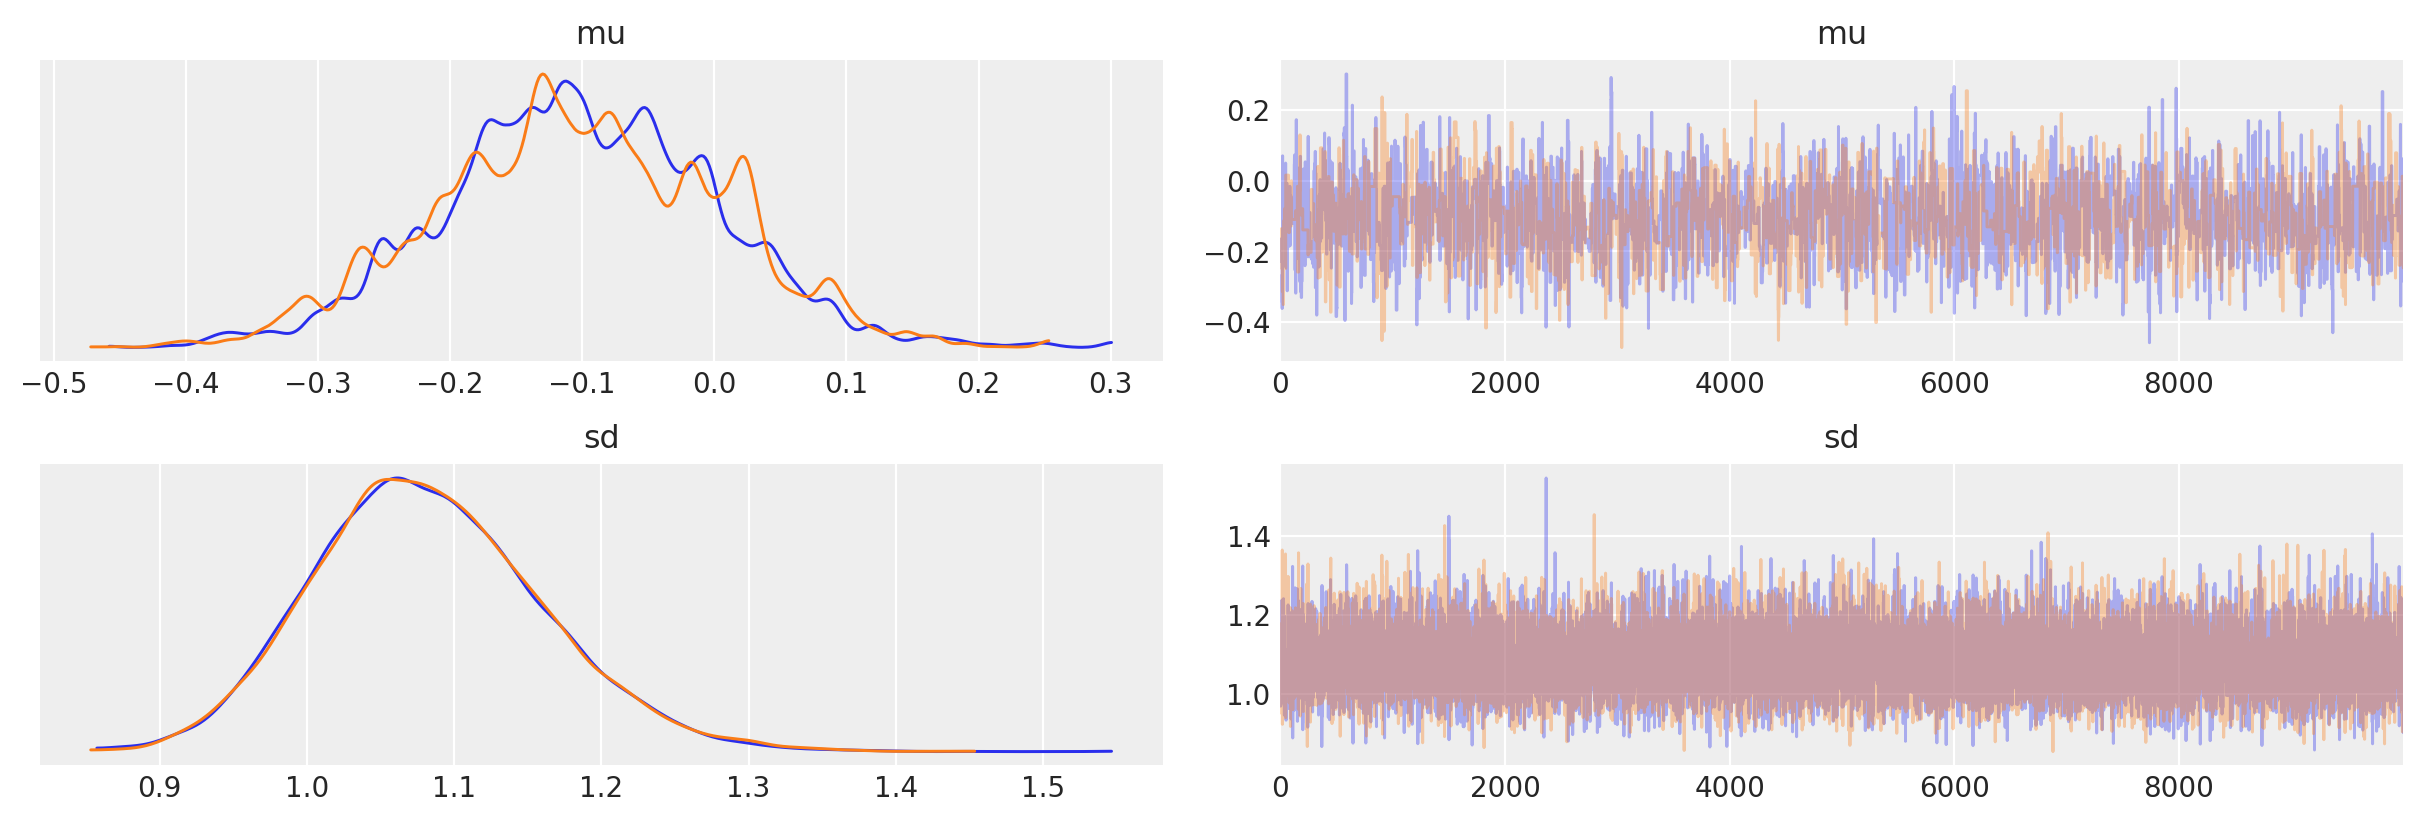

In [ ]:
az.plot_trace(trace)

 * muの分布のほうだけ、densityがやや凸凹しているし、サンプルのプロットも少し様子が違う。

In [ ]:
obs.observations.mean()

-0.10631476666497938

* pair plotで2変数の分布を同時に見る。
 * 周辺分布も表示させることができる。

/usr/local/lib/python3.7/dist-packages/arviz/plots/pairplot.py:223: UserWarning: Divergences data not found, plotting without divergences. Make sure the sample method provides divergences data and that it is present in the `diverging` field of `sample_stats` or `sample_stats_prior` or set divergences=False
  UserWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb7c889cb50>,
        None],
      dtype=object)

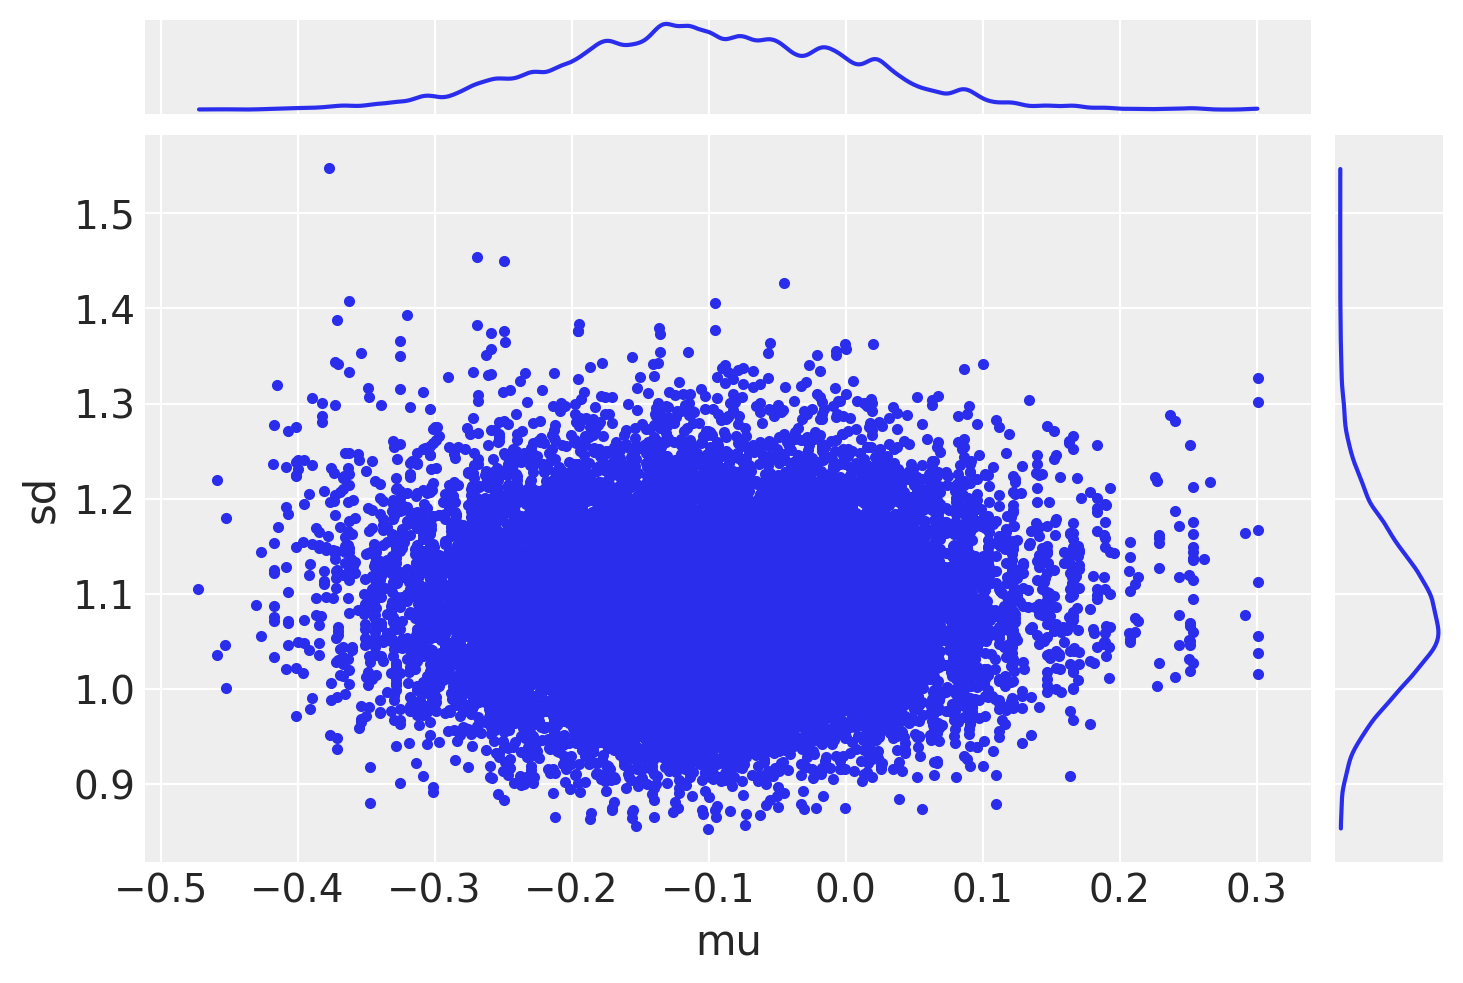

In [ ]:
az.plot_pair(trace, marginals=True, divergences=True)

### 3.3.2 自己相関
* 自己相関は小さいほど良い。
 * 小さいほど、サンプルが相互に独立だとみなせる。

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb7c7ef14d0>,
      dtype=object)

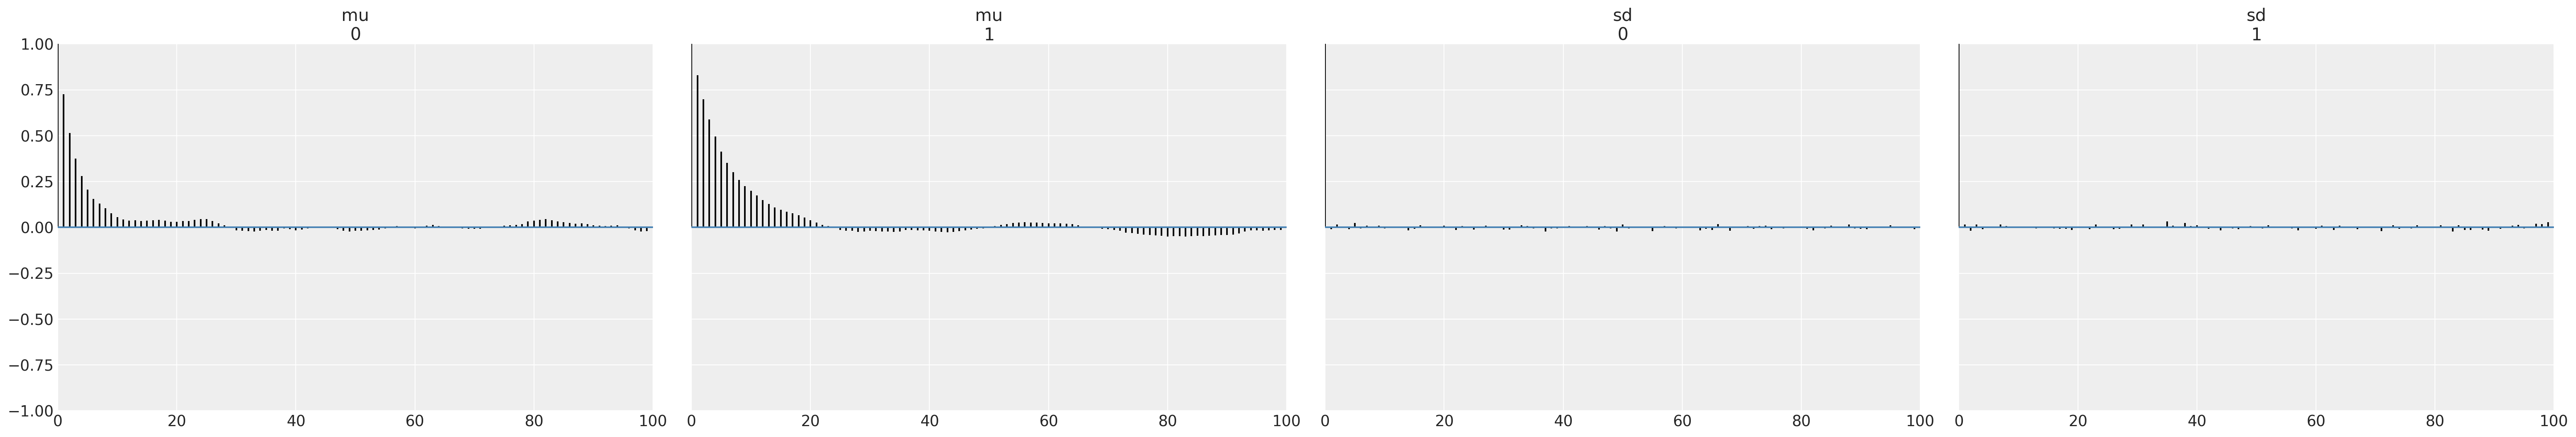

In [ ]:
az.plot_autocorr(trace, var_names=["mu", "sd"])

* muについては、自己相関が高くなってしまっている。

### 3.3.3 Gelman-Rubin統計量
* 定量的にサンプルの良し悪しを分析できる。
* R-hatと呼ばれる値が1に近いほど、連鎖の分布がより収束している。
 * http://www.omori.e.u-tokyo.ac.jp/MCMC/mcmc.pdf の6.2.2を参照。
* R-hatは1.05より小さいことが望ましいらしい。
 * https://www.youtube.com/watch?v=WbNmcvxRwow

In [ ]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,-0.103,0.105,-0.294,0.093,0.002,0.002,2073.0,2073.0,2080.0,2198.0,1.0
sd,1.083,0.077,0.943,1.229,0.001,0.000,19122.0,18890.0,19359.0,14811.0,1.0


* mcse, essについては、下記を参照。
 * https://mc-stan.org/docs/2_26/reference-manual/effective-sample-size-section.html

* muのほうのeffective sample sizeが小さい。これは問題。

 ### 3.3.4 HDI (Highest density interval)
* HDIが何であるかについては下記を参照。
 * http://web.sfc.keio.ac.jp/~maunz/BS14/BS14-11.pdf
 * https://www.sciencedirect.com/topics/mathematics/highest-density-interval 
* arvizのforest plot
  * デフォルトではHDI=94.0%の区間を図示する。
  * r_hat=TrueでR-hat統計量も図示する。

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb7bb536210>,
      dtype=object)

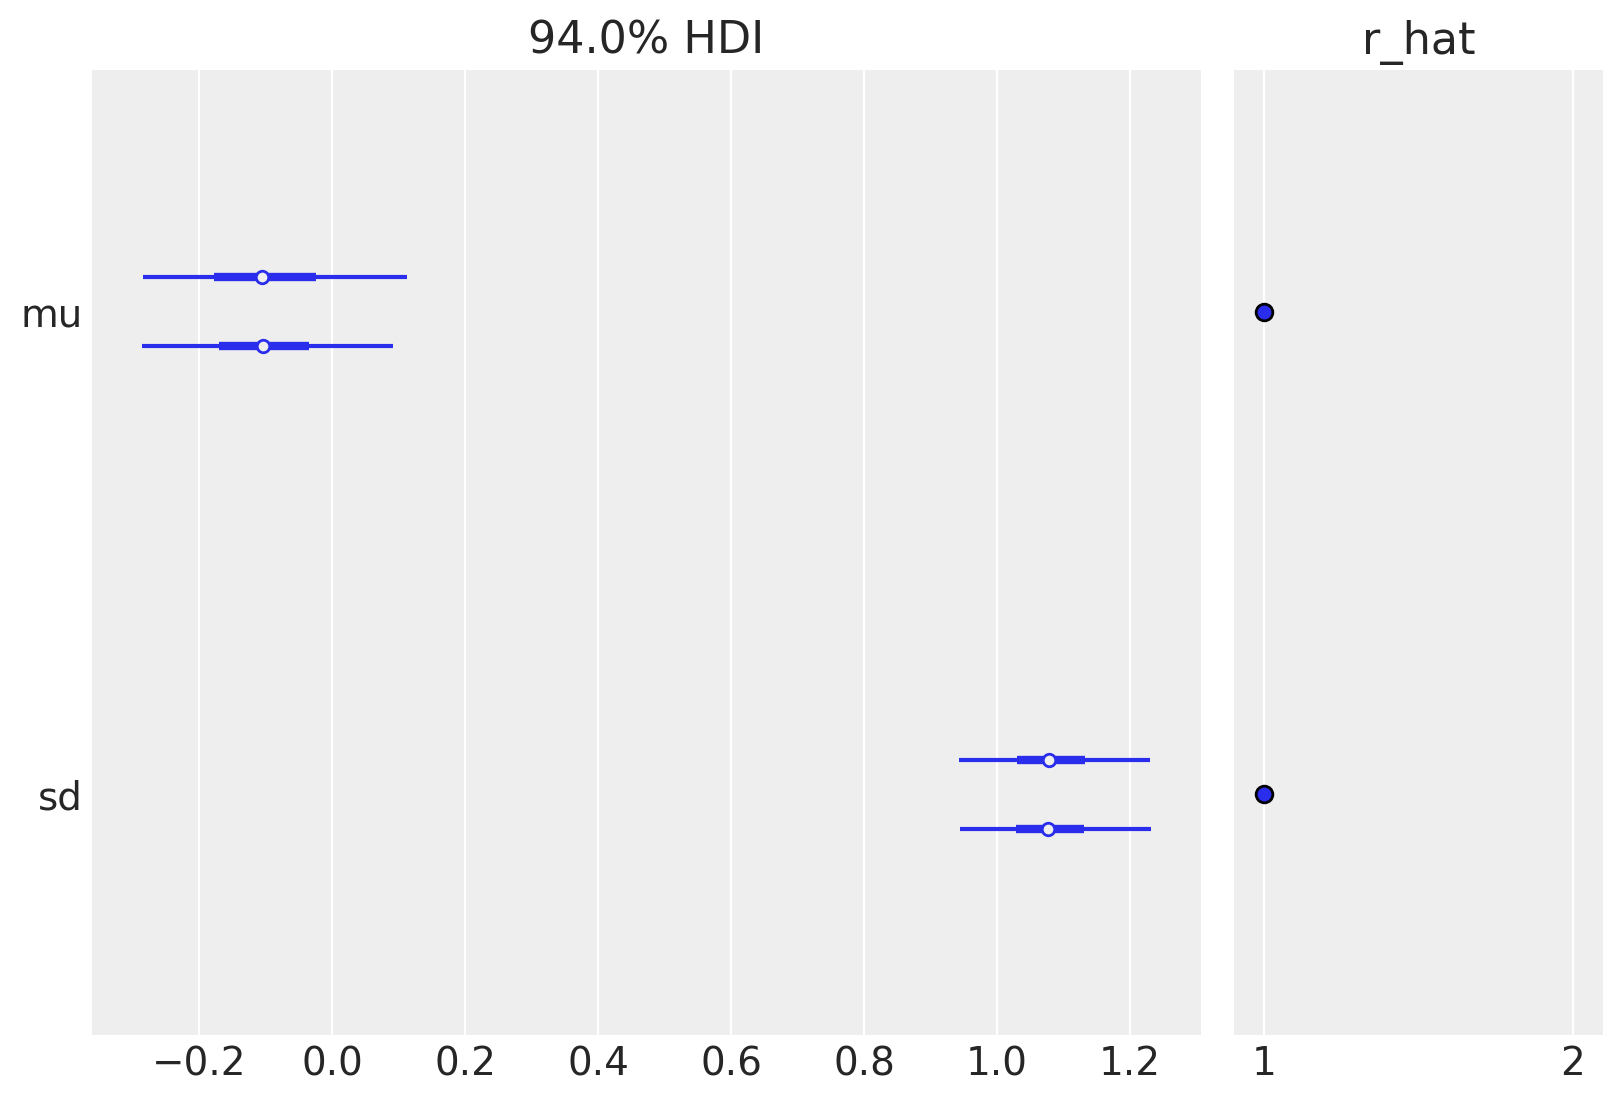

In [ ]:
az.plot_forest(trace, r_hat=True)

* ridge plot

Text(0.5, 1.0, 'Estimated mu and sd')

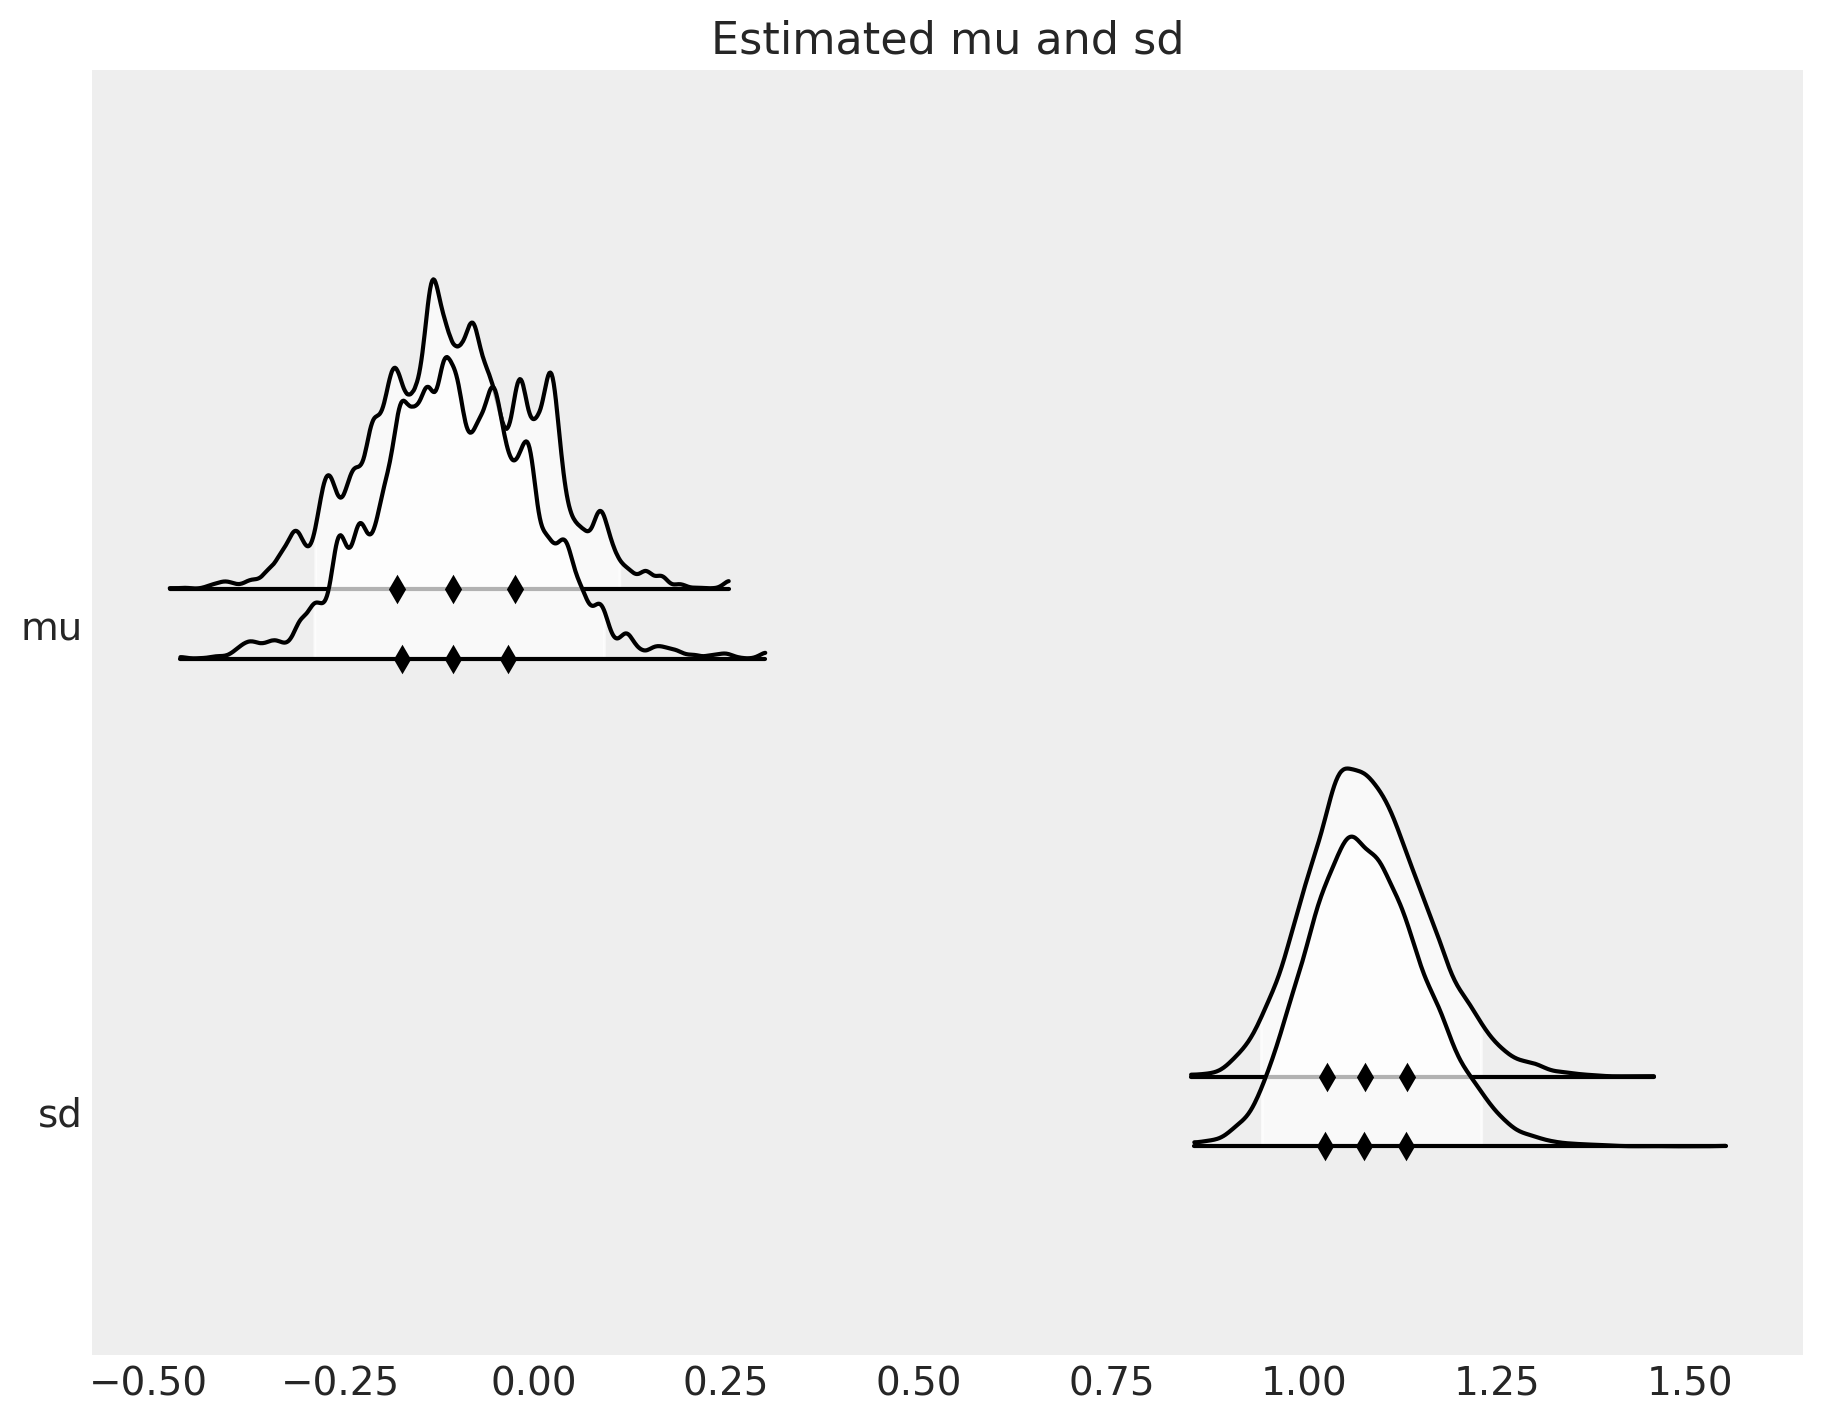

In [ ]:
axes = az.plot_forest(trace,
                      kind='ridgeplot',
                      ridgeplot_truncate=False,
                      ridgeplot_quantiles=[.25, .5, .75],
                      ridgeplot_alpha=.7,
                      colors='white',
                      figsize=(9, 7))
axes[0].set_title('Estimated mu and sd')

* 似ているが別の可視化。
 * https://sites.google.com/site/doingbayesiandataanalysis/ この本の流儀による可視化だそうです（がよく知りません・・・）。

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb7bafaf590>,
      dtype=object)

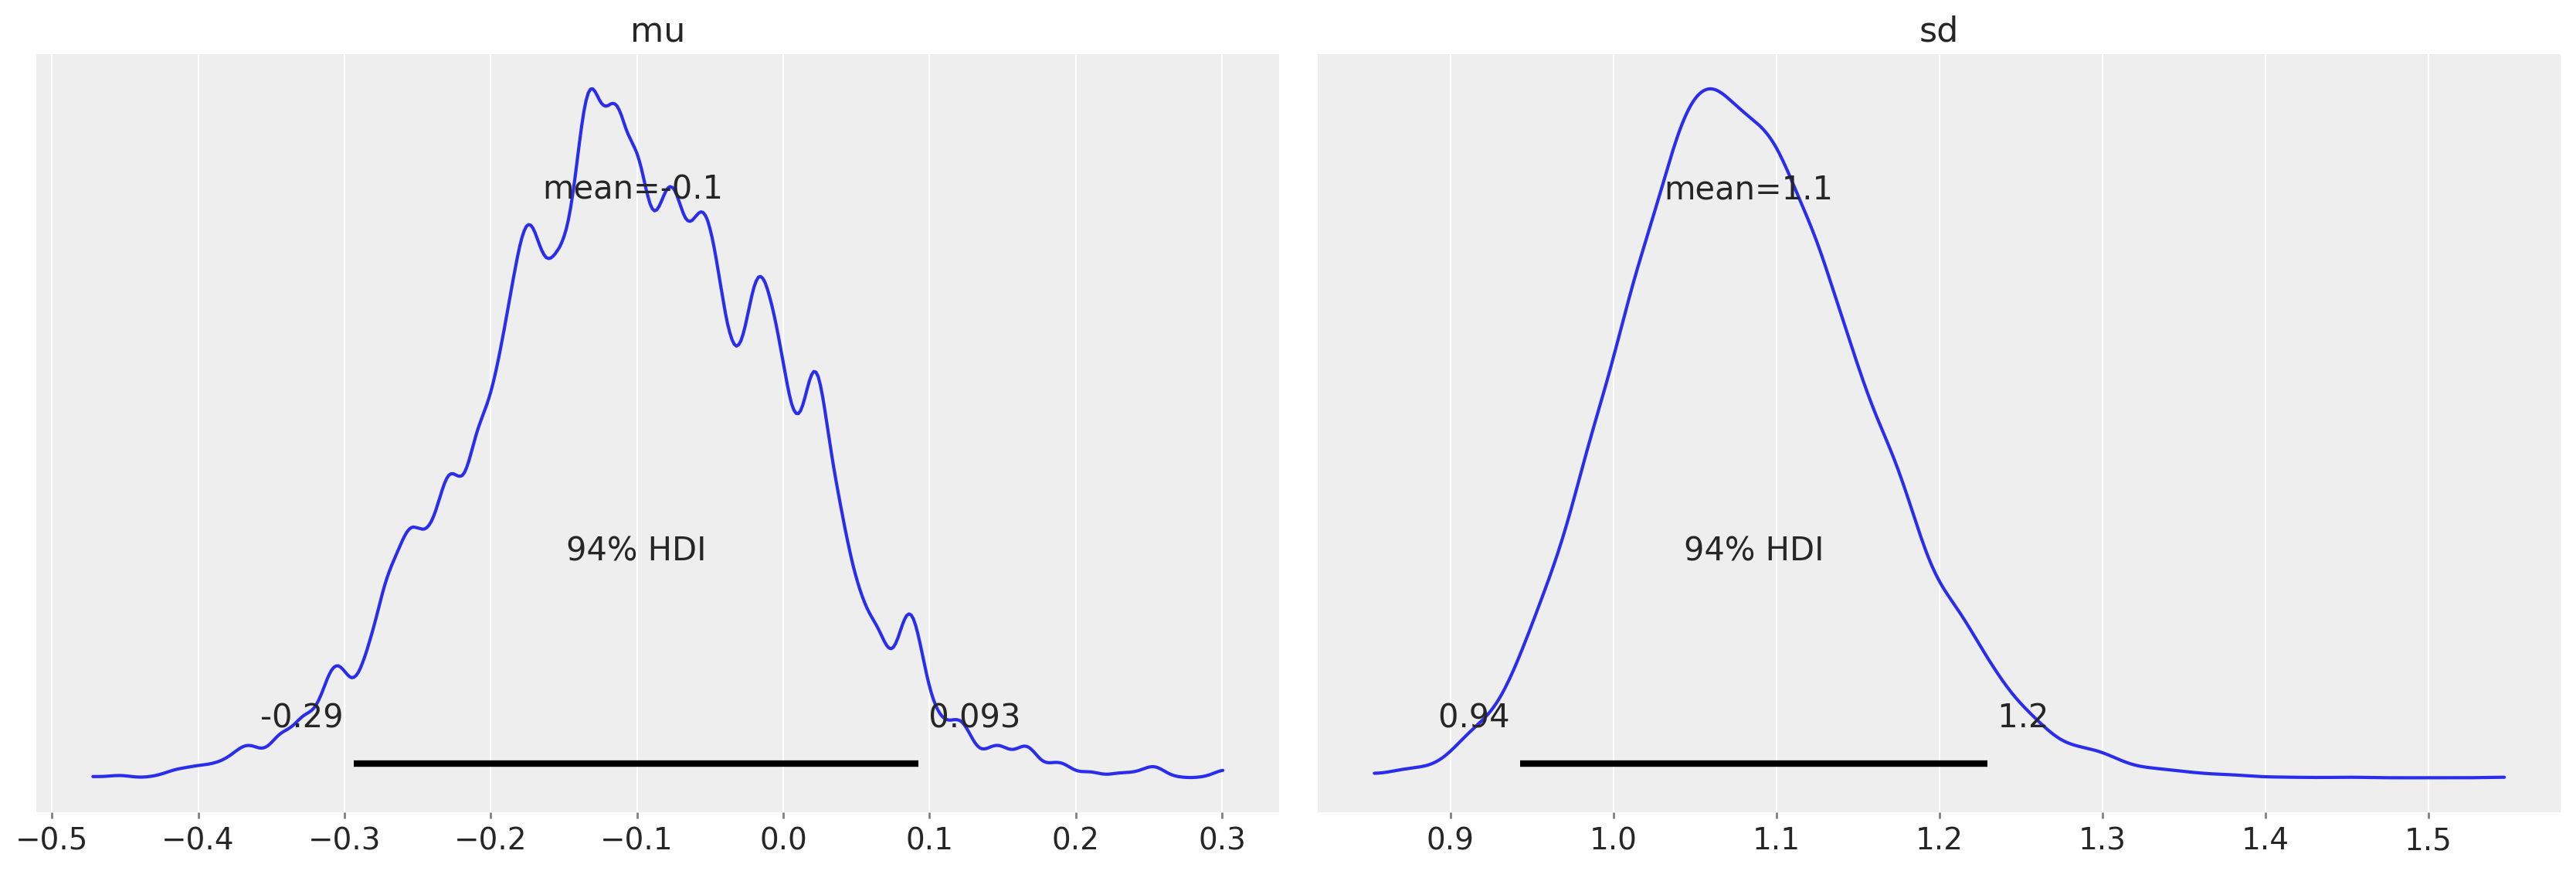

In [ ]:
az.plot_posterior(trace)

* 同じモデルで、二つのパラメータとも、メトロポリス法を使う。

In [ ]:
with model:
  step = pm.Metropolis()
  trace = pm.sample(10000, step=step, return_inferencedata=True, random_seed=SEED)

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [sd]
>Metropolis: [mu]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 8 seconds.
The number of effective samples is smaller than 10% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb7ba354f10>,
      dtype=object)

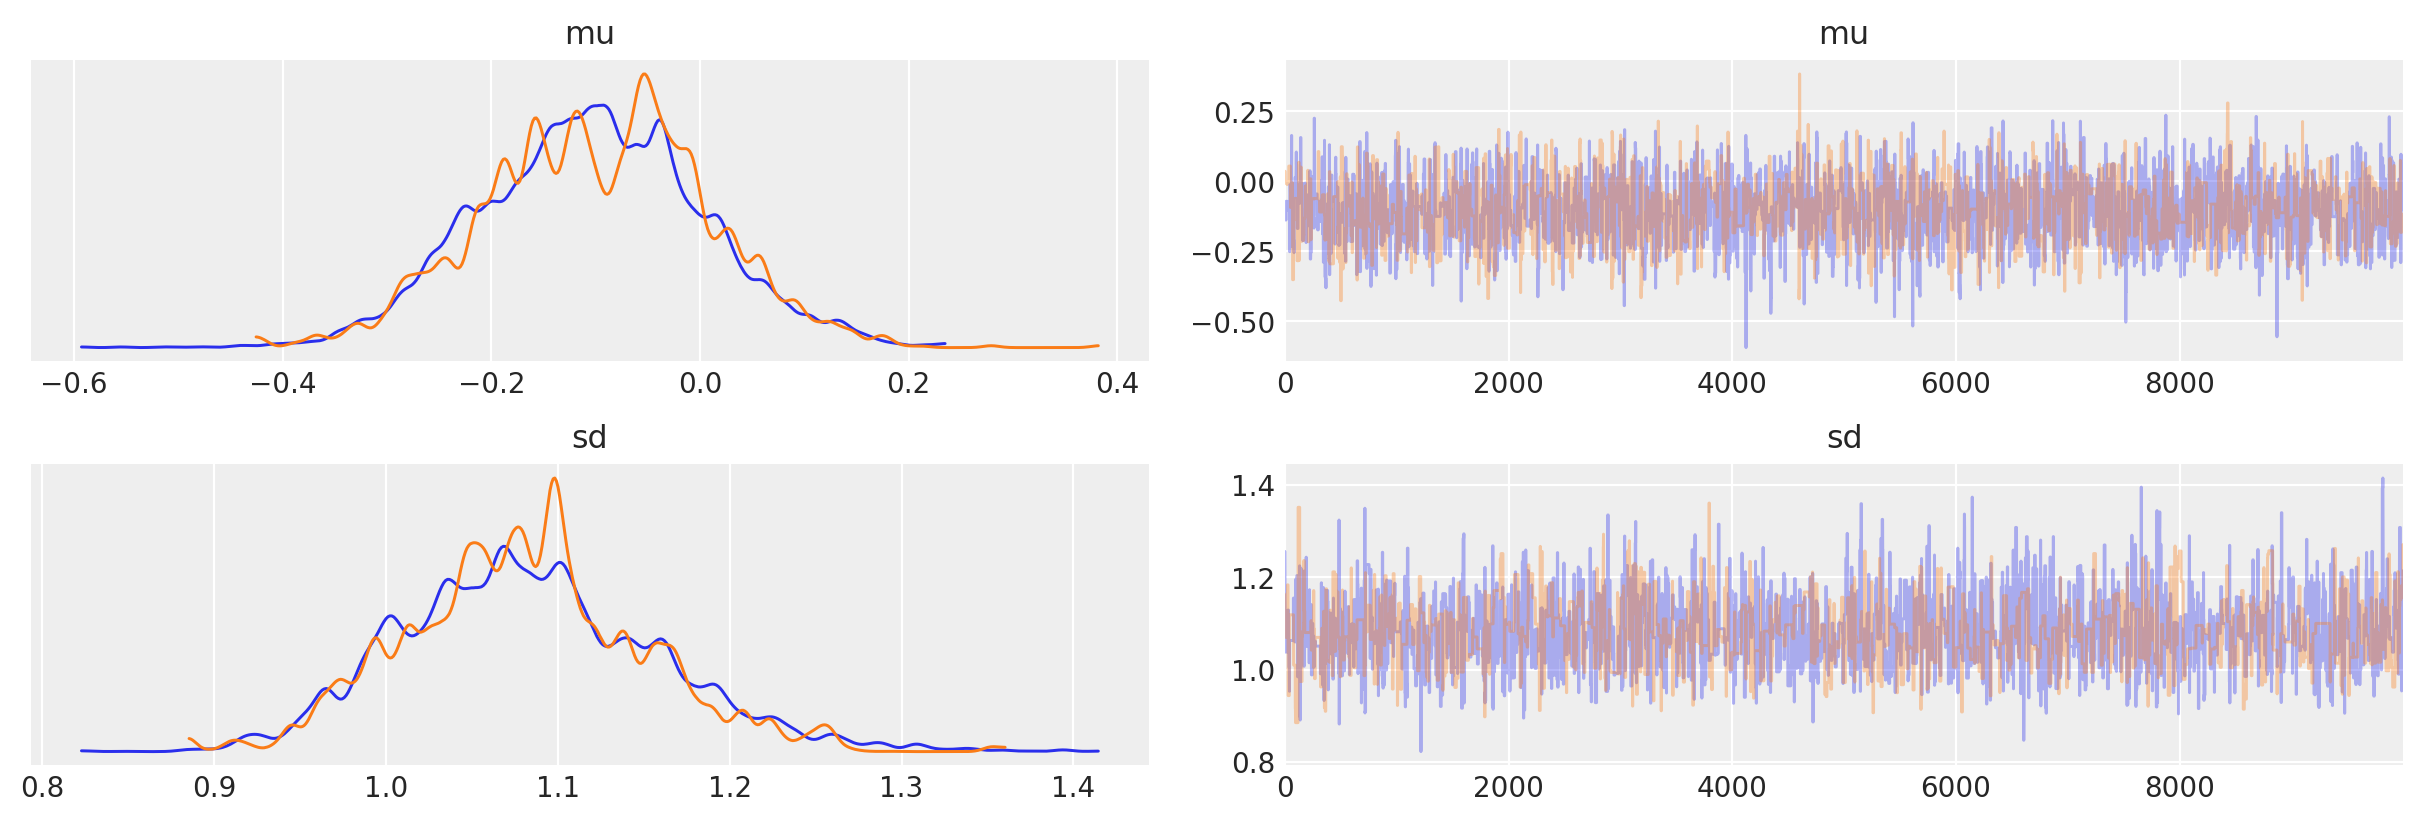

In [ ]:
az.plot_trace(trace)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb7ba323350>,
      dtype=object)

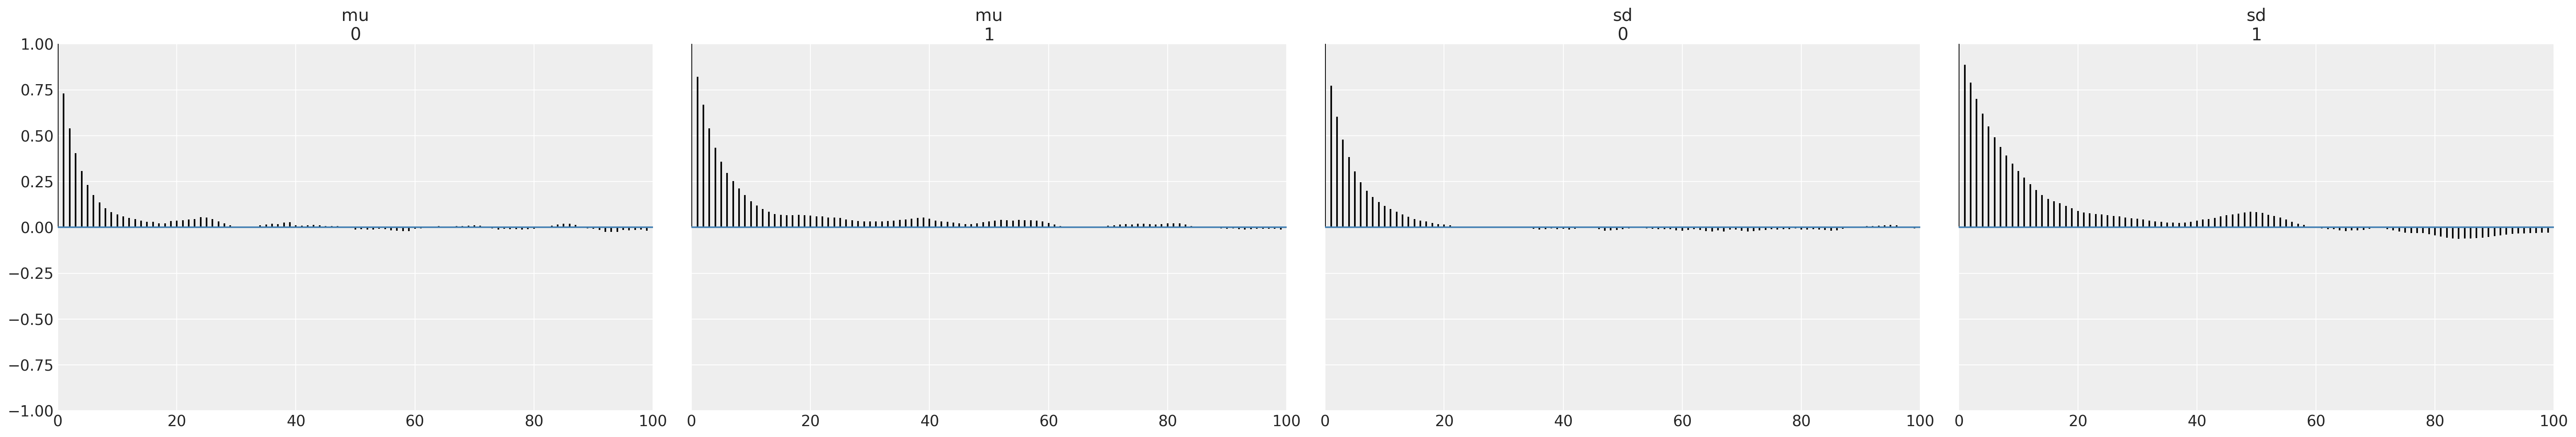

In [ ]:
az.plot_autocorr(trace, var_names=["mu", "sd"])

* どちらも自己相関が高くなってしまっている。

### 3.3.5 energy transition distributionとmarginal energy distributionによる分析

* 同じモデルで、二つのパラメータとも、デフォルトのNo-U-Turn Sampler (NUTS)を使う。

In [ ]:
with model:
  trace = pm.sample(10000, return_inferencedata=True, random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, mu]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 20 seconds.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb7ba1f8ad0>,
      dtype=object)

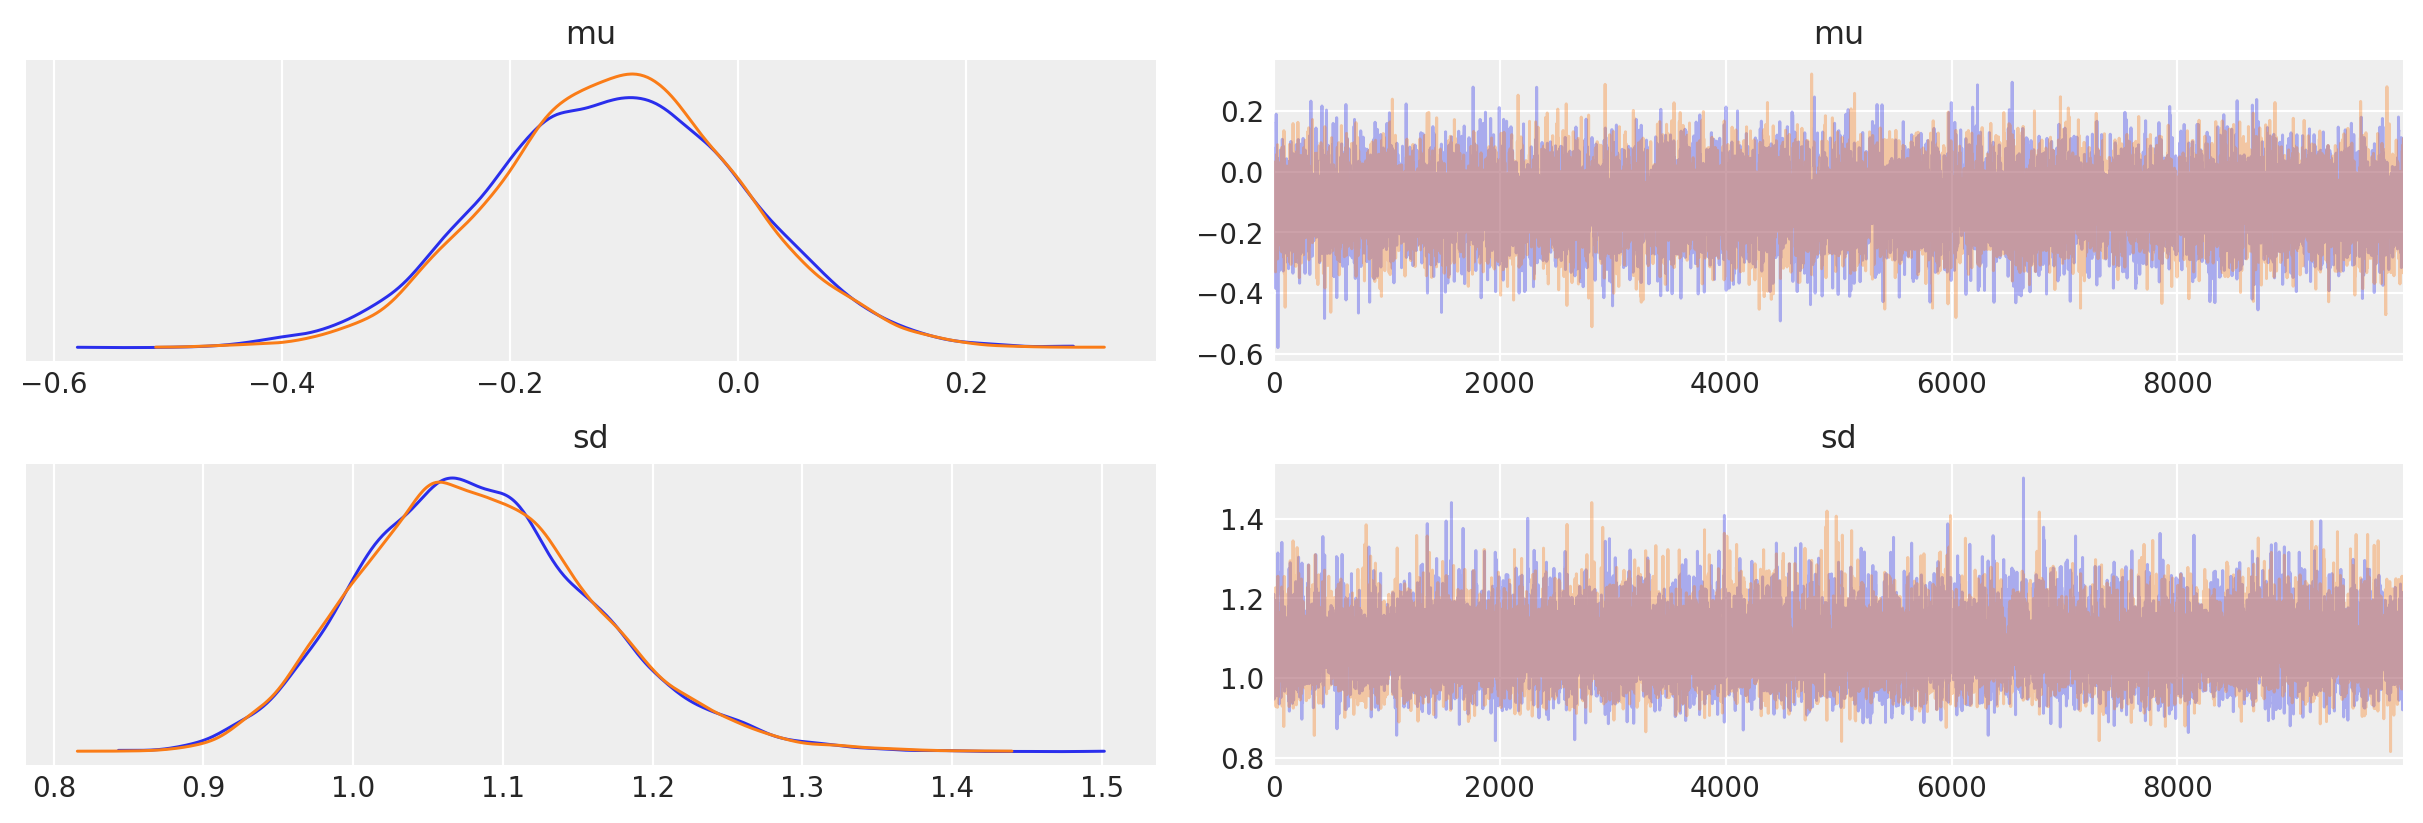

In [ ]:
az.plot_trace(trace)

In [ ]:
obs.observations.mean()

-0.10631476666497938

In [ ]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,-0.105,0.109,-0.303,0.105,0.001,0.001,15252.0,11683.0,15266.0,12430.0,1.0
sd,1.083,0.079,0.943,1.235,0.001,0.000,17064.0,16642.0,17604.0,14154.0,1.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb7b7f939d0>,
      dtype=object)

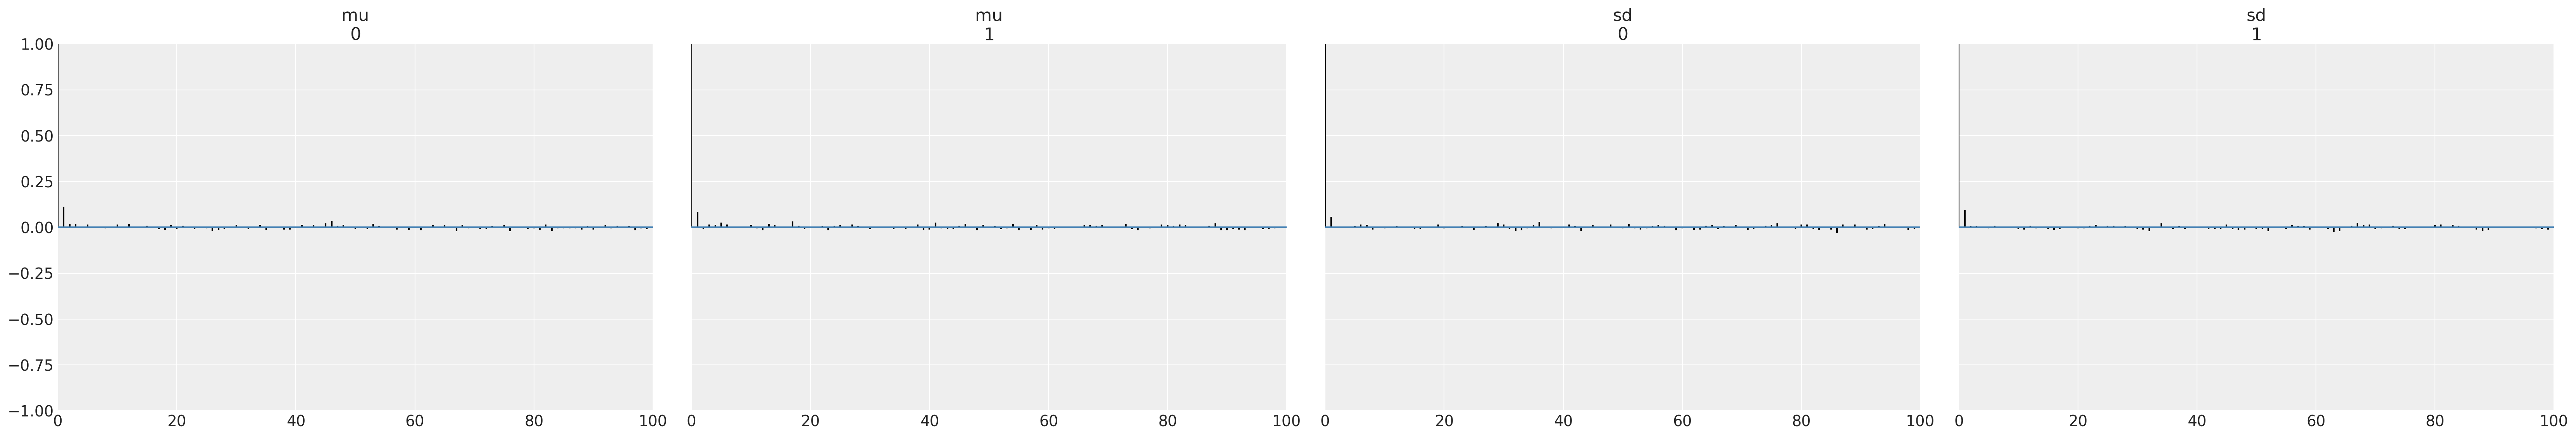

In [ ]:
az.plot_autocorr(trace, var_names=["mu", "sd"])

* 事後分布がheavy tailedな分布だった場合、chainがその重たい裾野を十分に踏査していない可能性がある。
* arvizのplot_energyで、"Energy transition"の分布の幅のほうが、"Marginal Energy"の分布のそれより、相当狭い場合が要注意！
 * BFMI (Bayesian
fraction of missing information)については https://arxiv.org/abs/1604.00695 の3.1を参照。
 * https://arxiv.org/abs/1701.02434 も参照。

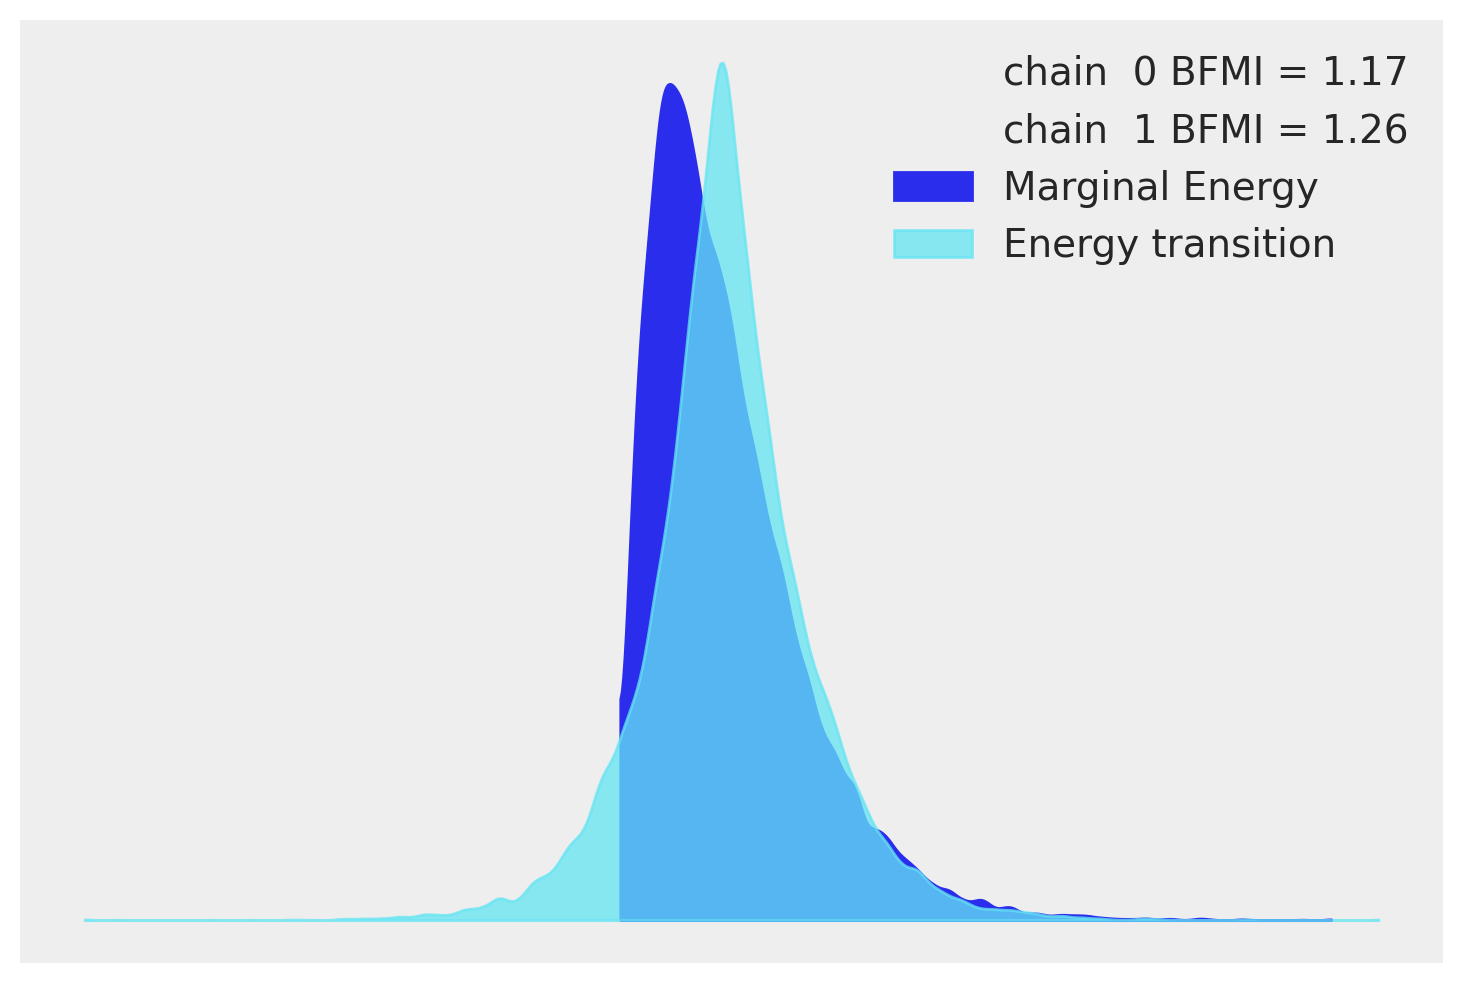

In [ ]:
az.plot_energy(trace)

* 参考資料
 * https://www.statlect.com/fundamentals-of-statistics/Markov-Chain-Monte-Carlo-diagnostics

## 3.4 Hamiltonian Monte Carlo (HMC)
* ここでは直感的な説明をするにとどめる。
* Stanのマニュアルを参考にした。
 * https://mc-stan.org/docs/2_26/reference-manual/hamiltonian-monte-carlo.html

### 3.4.1 補助変数
* 密度関数$p(\theta)$からのサンプリングを実現したいとする。
 * $p(\theta)$については、規格化定数は不明でも構わない。
* HMCでは、補助変数$\rho$を追加し、同時分布$p(\rho, \theta) = p(\rho|\theta)p(\theta)$からのサンプリングをおこなう。
* 多くの場合（Stanでも）、$\rho$の値が従う分布は、$\theta$に依存しない多変量正規分布だと仮定する。
$$\rho \sim \texttt{MultiNormal}(0, M)$$
 * $M$は対角成分しか持たないらしい（Stanのマニュアル参照）。

### 3.4.2 leapfrogアルゴリズム
* $V(\theta) \equiv - \ln p(\theta)$および$H(\rho, \theta) = - \ln p(\rho, \theta)$と定義する。
* leapfrogアルゴリズムでは、以下のように$\theta$を更新することで、サンプルのchainを作る。

1. $\rho$を$\texttt{MultiNormal}(0,M)$からdraw
 * つまり、$\rho \sim \texttt{MultiNormal}(0,M)$
2. 以下の一連の更新式を$L$回繰り返し実行する。
$$\begin{align}
\rho & \leftarrow \rho - \frac{\epsilon}{2}\frac{\partial V}{\partial \theta}
\notag \\
\theta & \leftarrow \theta + \epsilon M^{-1}\rho
\notag \\
\rho & \leftarrow \rho - \frac{\epsilon}{2}\frac{\partial V}{\partial \theta}
\end{align}$$
 * この結果、$\rho$は$\rho^*$へ、$\theta$は$\theta^*$へ、それぞれ更新されたとする。
3. この$\rho^*, \theta^*$を、確率$\min(1, \exp(H(\rho, \theta) - H(\rho^*, \theta^*)))$で、次のサンプルとして採用する。
 * 採用されなければ、元の$\rho,\theta$をそのまま次でも使う。



### 3.4.3 the no-U-turn sampling (NUTS) アルゴリズム
* leapfrogアルゴリズムで、$M$と$\epsilon$と$L$は、適切に調整すべきパラメータである。
* これらのパラメータを自動的に調整するアルゴリズムとしてHoffmanとGelmanにより提案されたのが、no-U-turn sampling (NUTS)アルゴリズムである。（終）

### 3.4.4 divergence
* leapfrogアルゴリズムは、$\frac{\partial V}{\partial \theta}$を使っている。
* 雰囲気を言うと、これは、本当なら$p(\theta)$の地形に沿って滑らかに動きたいところを、一階の微分を使って近似的に動いている。
* 近似であるため、本当ならそう動きたいという軌道から、外れてしまうこともある。
* この外れ方が非常に大きくなってしまうことを、divergenceと呼ぶ。
* divergenceが大きいと、得られたサンプルが所望の密度関数からのサンプルとみなせない。